In [76]:
import pandas as pd
import numpy as np
import unidecode
import unicodedata
import sys
import os
import shap
import re
from pathlib import Path

# Sklearn
from sklearn.metrics import mean_absolute_error, r2_score

# Gradient boosting
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

project_root = None
p = Path.cwd()
for parent in [p] + list(p.parents):
    if (parent / "src").exists():
        project_root = parent
        break

if project_root:
    sys.path.append(str(project_root))

# Data loading
from src.data_loaders.load_data import load_all

# Preprocessing
from src.preprocessing.clean_injuries import clean_injury_df
from src.preprocessing.clean_stats import clean_stats_df
from src.preprocessing.clean_matches import clean_match_df
from src.preprocessing.merge_injury_stats import merge_injury_and_stats
from src.preprocessing.merge_injury_matches import merge_injuries_with_matches
from src.preprocessing.rename_finaldf_cols import rename_final_df_columns

# Feature engineering
from src.feature_engineering.injury_history import add_injury_history_features
from src.feature_engineering.match_features import build_team_match_frame, add_match_features
from src.feature_engineering.negative_sampling import generate_negative_samples, get_recommended_strategy
from src.feature_engineering.classification import build_classification_dataset
from src.feature_engineering.imputation import impute_features
from src.feature_engineering.severity import (
    build_severity_dataset, 
    clean_severity_dataset,
    build_injury_features,
    add_severity_prediction_features,
    get_severity_feature_descriptions,
    add_team_recovery_features,
    add_player_injury_history_features
)
from src.feature_engineering.workload import add_workload_metrics
from src.feature_engineering.archetype import build_player_archetype_features
from src.feature_engineering.temporal_features import add_temporal_features, add_fixture_density_features
from src.feature_engineering.position_features import add_position_risk_features, add_position_workload_interaction
from src.feature_engineering.player_stats_features import load_player_stats, add_player_stats_features

# Utilities
from src.utils.names import extract_feature_names
from src.utils.data_utils import sanitize_column_names, prepare_features_for_lgb, rmse

# Baseline models
from src.models.baselines import (
    prepare_training_data,
    train_logistic_regression,
    train_random_forest,
    train_dummy_classifier,
    evaluate_classifier as evaluate_baseline_classifier
)

# Classification models
from src.models.classification import (
    get_classification_splits,
    get_smote_splits,
    get_temporal_splits,
    get_stratified_temporal_splits,
    train_lightgbm,
    train_lightgbm_smote,
    train_xgboost,
    train_xgboost_smote,
    train_xgboost_tuned,
    run_optuna_tuning,
    evaluate_classifier,
    evaluate_thresholds,
    explain_model_with_shap,
    explain_xgboost_shap,
    run_full_catboost_class_tuning
)
from src.models.smote_utils import smote_compare
from src.models.classification_ensemble import run_full_ensemble
from src.models.classification_shap import (
    compute_ensemble_shap, 
    compute_stacking_ensemble_shap,
    build_final_output_df,
    build_temporal_output_df,
    explain_player_ensemble, 
    shap_waterfall_player
)
from src.models.stacking_ensemble import StackingEnsemble, train_stacking_ensemble, compare_ensemble_vs_individual

# Severity models
from src.models.severity import (
    get_severity_splits,
    get_temporal_severity_splits,
    get_filtered_temporal_severity_splits,
    train_lightgbm_severity,
    train_xgboost_severity,
    train_catboost_severity,
    run_full_catboost_severity_tuning,
    evaluate_severity,
    # Classification alternative
    SEVERITY_LABELS,
    get_severity_classification_splits,
    train_severity_classifier,
    evaluate_severity_classifier,
    # High-level training functions
    train_severity_regressors,
    compare_severity_models,
    diagnose_severity_target
)
from src.models.severity_ensemble import build_severity_ensemble, evaluate_severity_ensemble

# Archetype models
from src.models.archetype import cluster_players, plot_pca_clusters, prepare_archetype_features
from src.models import compute_stacking_ensemble_shap, build_temporal_output_df

# Inference
from src.inference.inference_pipeline import build_full_inference_df
from src.inference import build_inference_df_with_ensemble
from src.inference.risk_card import build_risk_card

# Dashboard
from src.dashboard.player_dashboard import build_player_dashboard, get_latest_snapshot

In [2]:
#datasets

data = load_all()
injury_df = data["injuries"]
match_df  = data["matches"]
stats_df  = data["stats"]

In [3]:
#inspect injury df

injury_df.head()

,Name,Team Name,Position,Age,Season,FIFA rating,Injury,Date of Injury,Date of return,Match1_before_injury_Result,...,Match1_after_injury_GD,Match1_after_injury_Player_rating,Match2_after_injury_Result,Match2_after_injury_Opposition,Match2_after_injury_GD,Match2_after_injury_Player_rating,Match3_after_injury_Result,Match3_after_injury_Opposition,Match3_after_injury_GD,Match3_after_injury_Player_rating
0,Jamaal Lascelles,Newcastle,Center Back,26,2019/20,77,Knee injury,"Nov 9, 2019","Jan 13, 2020",draw,...,1,7.1,draw,Everton,0,6.2,draw,Norwich City,0,6.7
1,Fabian Schär,Newcastle,Center Back,28,2019/20,79,Knee injury,"Oct 20, 2019","Nov 24, 2019",lose,...,N.A.,N.A.,N.A.,N.A.,N.A.,N.A.,N.A.,N.A.,N.A.,N.A.
2,Fabian Schär,Newcastle,Center Back,28,2019/20,79,Hamstring strain,"Jan 2, 2020","Jan 17, 2020",lose,...,0,6(S),lose,Arsenal,-4,N.A.,lose,Crystal Palace,-1,6.5
3,Fabian Schär,Newcastle,Center Back,28,2019/20,79,Shoulder injury,"Jul 16, 2020","Sep 28, 2020",lose,...,N.A.,N.A.,N.A.,N.A.,N.A.,N.A.,N.A.,N.A.,N.A.,N.A.
4,Paul Dummett,Newcastle,Center Back,28,2019/20,75,Groin injury,"Dec 22, 2019","Jan 10, 2020",win,...,N.A.,N.A.,N.A.,N.A.,N.A.,N.A.,N.A.,N.A.,N.A.,N.A.


In [4]:
injury_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656 entries, 0 to 655
Data columns (total 42 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Name                                656 non-null    object
 1   Team Name                           656 non-null    object
 2   Position                            656 non-null    object
 3   Age                                 656 non-null    int64 
 4   Season                              656 non-null    object
 5   FIFA rating                         656 non-null    int64 
 6   Injury                              656 non-null    object
 7   Date of Injury                      656 non-null    object
 8   Date of return                      656 non-null    object
 9   Match1_before_injury_Result         656 non-null    object
 10  Match1_before_injury_Opposition     656 non-null    object
 11  Match1_before_injury_GD             656 non-null    object

In [5]:
injury_df.isna().sum()

Name                                  0
Team Name                             0
Position                              0
Age                                   0
Season                                0
FIFA rating                           0
Injury                                0
Date of Injury                        0
Date of return                        0
Match1_before_injury_Result           0
Match1_before_injury_Opposition       0
Match1_before_injury_GD               0
Match1_before_injury_Player_rating    0
Match2_before_injury_Result           0
Match2_before_injury_Opposition       0
Match2_before_injury_GD               0
Match2_before_injury_Player_rating    0
Match3_before_injury_Result           0
Match3_before_injury_Opposition       0
Match3_before_injury_GD               0
Match3_before_injury_Player_rating    0
Match1_missed_match_Result            0
Match1_missed_match_Opposition        0
Match1_missed_match_GD                0
Match2_missed_match_Result            0


In [6]:
# inspect match df

match_df.head()

,Season_End_Year,Wk,Date,Home,HomeGoals,AwayGoals,Away,FTR
0,1993,1,1992-08-15,Coventry City,2,1,Middlesbrough,H
1,1993,1,1992-08-15,Leeds United,2,1,Wimbledon,H
2,1993,1,1992-08-15,Sheffield Utd,2,1,Manchester Utd,H
3,1993,1,1992-08-15,Crystal Palace,3,3,Blackburn,D
4,1993,1,1992-08-15,Arsenal,2,4,Norwich City,A


In [7]:
match_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12026 entries, 0 to 12025
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Season_End_Year  12026 non-null  int64 
 1   Wk               12026 non-null  int64 
 2   Date             12026 non-null  object
 3   Home             12026 non-null  object
 4   HomeGoals        12026 non-null  int64 
 5   AwayGoals        12026 non-null  int64 
 6   Away             12026 non-null  object
 7   FTR              12026 non-null  object
dtypes: int64(4), object(4)
memory usage: 751.8+ KB


In [8]:
match_df.isna().sum()

Season_End_Year    0
Wk                 0
Date               0
Home               0
HomeGoals          0
AwayGoals          0
Away               0
FTR                0
dtype: int64

In [9]:
#inspect stats df

stats_df.head()

,PlayerID,Player,Squad,League,Nation,Pos,Age,Born,Season,MP,...,The Best FIFA Mens Player,UEFA Best Player,UCL_MP,UCL_Gls,UCL_xG,UCL_Ast,UCL_xA,UCL_KP,UCL_GCA,UCL_SCA
0,4,Alexander Strehmel,Stuttgart,Bundesliga,GER,"DF,MF",24.0,1968.0,1992-1993,20.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,Alexander Strehmel,Stuttgart,Bundesliga,GER,"DF,MF",25.0,1968.0,1993-1994,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,Alexander Strehmel,Unterhaching,Bundesliga,GER,"DF,MF",31.0,1968.0,1999-2000,25.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Alexander Strehmel,Unterhaching,Bundesliga,GER,"DF,MF",32.0,1968.0,2000-2001,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6,Alois Reinhardt,Bayern Munich,Bundesliga,GER,DF,30.0,1961.0,1992-1993,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92170 entries, 0 to 92169
Columns: 120 entries, PlayerID to UCL_SCA
dtypes: float64(113), int64(1), object(6)
memory usage: 84.4+ MB


In [11]:
stats_df.isna().sum()

PlayerID    0
Player      0
Squad       0
League      0
Nation      0
           ..
UCL_Ast     0
UCL_xA      0
UCL_KP      0
UCL_GCA     0
UCL_SCA     0
Length: 120, dtype: int64

In [12]:
injury_df = clean_injury_df(data["injuries"])
stats_df  = clean_stats_df(data["stats"])
match_df  = clean_match_df(data["matches"])

In [13]:
injury_df.isna().sum()

name                                    0
player_team                             0
position                                0
age                                     0
season                                  0
fifa_rating                             0
injury                                  0
date_of_injury                          1
date_of_return                          6
match1_before_injury_result            65
match1_before_injury_opposition        65
match1_before_injury_gd                65
match1_before_injury_player_rating     67
match2_before_injury_result           101
match2_before_injury_opposition       101
match2_before_injury_gd               101
match2_before_injury_player_rating    102
match3_before_injury_result           157
match3_before_injury_opposition       157
match3_before_injury_gd               157
match3_before_injury_player_rating    157
player_name                             0
season_year                             0
injury_datetime                   

In [14]:
#make sure common rows in both columns are returned

set(injury_df["player_name"]) & set(stats_df["player_name"])

{'aaron hickey',
 'aaron lennon',
 'aaron wan-bissaka',
 'abdoulaye doucoure',
 'alex iwobi',
 'alex moreno',
 'alexander isak',
 'alexandre lacazette',
 'allan',
 'allan saint-maximin',
 'amadou onana',
 'ameen al-dakhil',
 'andre gomes',
 'andros townsend',
 'andy carroll',
 'anthony gordon',
 'anthony martial',
 'anwar el ghazi',
 'ashley barnes',
 'ashley westwood',
 'ashley young',
 'axel tuanzebe',
 'ben davies',
 'ben godfrey',
 'ben mee',
 'ben white',
 'bernard',
 'bernd leno',
 'bertrand traore',
 'beto',
 'bjorn engels',
 'boubacar kamara',
 'brandon williams',
 'bruno fernandes',
 'bruno guimaraes',
 'bryan gil',
 'bryan mbeumo',
 'bukayo saka',
 'callum wilson',
 'calum chambers',
 'cedric soares',
 'cenk tosun',
 'charlie taylor',
 'chris wood',
 'christian eriksen',
 'ciaran clark',
 'connor roberts',
 'dale stephens',
 'dan burn',
 'dani ceballos',
 'daniel james',
 'david luiz',
 'david raya',
 'davinson sanchez',
 'deandre yedlin',
 'dele alli',
 'diego carlos',
 'dji

In [15]:
set(injury_df["player_team"]) & set(stats_df["player_team"])

{'arsenal',
 'aston villa',
 'brentford',
 'burnley',
 'everton',
 'manchester united',
 'newcastle united',
 'tottenham'}

In [16]:
set(injury_df["season_year"]) & set(stats_df["season_year"])

{'2019-2020', '2020-2021', '2021-2022', '2022-2023', '2023-2024'}

In [17]:
#merge injury and stats dataframes using player_name, player_team, and season_year using a left join

merged_df = merge_injury_and_stats(injury_df, stats_df)

In [18]:
#confirm merge works

merged_df.info()
merged_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656 entries, 0 to 655
Columns: 143 entries, name to ucl_sca
dtypes: datetime64[ns](3), float64(114), int64(2), object(24)
memory usage: 733.0+ KB


,name,player_team,position,age_x,season_x,fifa_rating,injury,date_of_injury,date_of_return,match1_before_injury_result,...,the best fifa mens player,uefa best player,ucl_mp,ucl_gls,ucl_xg,ucl_ast,ucl_xa,ucl_kp,ucl_gca,ucl_sca
0,Jamaal Lascelles,newcastle united,Center Back,26,2019/20,77,Knee injury,2019-11-09,2020-01-13,draw,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Fabian Schär,newcastle united,Center Back,28,2019/20,79,Knee injury,2019-10-20,2019-11-24,lose,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Fabian Schär,newcastle united,Center Back,28,2019/20,79,Hamstring strain,2020-01-02,2020-01-17,lose,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Fabian Schär,newcastle united,Center Back,28,2019/20,79,Shoulder injury,2020-07-16,2020-09-28,lose,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Paul Dummett,newcastle united,Center Back,28,2019/20,75,Groin injury,2019-12-22,2020-01-10,win,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
match_df.columns

Index(['season_end_year', 'wk', 'date', 'home_team', 'homegoals', 'awaygoals',
       'away_team', 'ftr', 'match_date', 'season_year'],
      dtype='object')

In [20]:
#build team match frame

team_matches = build_team_match_frame(match_df)

In [21]:
team_matches.head()

,match_date,season_year,team,opp_team,goals_for,goals_against,venue
0,1992-08-15,1992-1993,arsenal,norwich city,2,4,home
1,1992-08-18,1992-1993,arsenal,blackburn,0,1,away
2,1992-08-23,1992-1993,arsenal,liverpool,2,0,away
3,1992-08-26,1992-1993,arsenal,oldham athletic,2,0,home
4,1992-08-29,1992-1993,arsenal,sheffield weds,2,1,home


In [22]:
#add features

team_matches = add_match_features(team_matches)

In [23]:
#workload metrics

team_matches = add_workload_metrics(team_matches)

In [24]:
final_df = merge_injuries_with_matches(merged_df, team_matches)

In [25]:
final_df.head()

,name,player_team,position,age_x,season_x,fifa_rating,injury,date_of_injury,date_of_return,match1_before_injury_result,...,loss_streak,dummy_load,acute_load,chronic_load,acwr,monotony,strain,fatigue_index,workload_slope,spike_flag
0,Granit Xhaka,arsenal,Defensive Midfielder,27,2019/20,83,Back injury,2019-08-12,2019-08-23,win,...,0.0,1.0,1.0,1.0,1.00,1.000000e+09,1.000000e+09,0.0,-3.000000e-01,0.0
1,Alexandre Lacazette,arsenal,Center Forward,29,2019/20,85,Ankle injury,2019-09-02,2019-10-20,win,...,0.0,1.0,1.0,4.0,0.25,1.000000e+09,1.000000e+09,-3.0,1.019104e-16,0.0
2,Dani Ceballos,arsenal,Central Midfielder,23,2019/20,80,Torn muscle bundle,2019-11-07,2019-12-31,lose,...,0.0,1.0,2.0,4.0,0.50,1.000000e+09,2.000000e+09,-2.0,2.000000e-01,0.0
3,Sead Kolasinac,arsenal,Center Back,27,2019/20,80,Hamstring injury,2019-11-17,2019-11-30,draw,...,1.0,1.0,1.0,4.0,0.25,1.000000e+09,1.000000e+09,-3.0,-1.000000e-01,0.0
4,Héctor Bellerín,arsenal,Right Back,25,2019/20,81,Hamstring injury,2019-12-06,2020-01-14,lose,...,1.0,1.0,2.0,4.0,0.50,1.000000e+09,2.000000e+09,-2.0,5.378863e-17,0.0


In [26]:
final_df.isna().sum()

name              0
player_team       0
position          0
age_x             0
season_x          0
                 ..
monotony          1
strain            1
fatigue_index     1
workload_slope    1
spike_flag        1
Length: 177, dtype: int64

In [27]:
final_df = rename_final_df_columns(final_df)

In [28]:
final_df = add_injury_history_features(final_df)

In [29]:
final_df[[
    "name",
    "injury_datetime",
    "previous_injuries",
    "days_since_last_injury",
    "matches_last_7",
    "rest_days_before_injury"
]].head()

,name,injury_datetime,previous_injuries,days_since_last_injury,matches_last_7,rest_days_before_injury
0,Granit Xhaka,2019-08-12 23:59:00,0,999.0,0.0,91.0
1,Alexandre Lacazette,2019-09-02 23:59:00,0,999.0,0.0,8.0
2,Dani Ceballos,2019-11-07 23:59:00,0,999.0,1.0,6.0
3,Sead Kolasinac,2019-11-17 23:59:00,0,999.0,0.0,7.0
4,Héctor Bellerín,2019-12-06 23:59:00,0,999.0,1.0,4.0


In [30]:
final_df[[
    "name",
    "injury_datetime",
    "previous_injuries",
    "days_since_last_injury",
    "matches_last_7",
    "rest_days_before_injury"
]].tail()

,name,injury_datetime,previous_injuries,days_since_last_injury,matches_last_7,rest_days_before_injury
650,Richarlison,2023-11-10 23:59:00,6,336.0,0.0,8.0
651,Rodrigo Bentacur,2023-11-27 23:59:00,4,288.0,0.0,8.0
652,Giovani Lo Celso,2023-12-14 23:59:00,8,107.0,0.0,8.0
653,Giovani Lo Celso,2024-01-06 23:59:00,9,23.0,0.0,8.0
654,Giovani Lo Celso,2024-05-15 23:59:00,10,130.0,0.0,8.0


In [31]:
# Create negative samples with IMPROVED strategy
# Options: "basic", "stratified", "matched", "hard_negative"

# Get recommended strategy based on data imbalance
n_injuries = len(final_df)
n_matches = len(team_matches)
recommended = get_recommended_strategy(n_injuries, n_matches)
print(f"Recommended sampling strategy: {recommended}")
print(f"  (based on {n_injuries} injuries vs {n_matches} match records)")

# Use stratified sampling by default (maintains temporal distribution)
negative_samples = generate_negative_samples(
    team_matches, 
    injury_df, 
    sample_frac=0.3,
    strategy="stratified"  # or "matched" for case-control, "hard_negative" for challenging examples
)
print(f"Generated {len(negative_samples)} negative samples")


Recommended sampling strategy: stratified
  (based on 655 injuries vs 24052 match records)
Generated 194195 negative samples


In [32]:
# Build final classification dataset (WITH date column for temporal validation)
injury_risk_df = build_classification_dataset(final_df, negative_samples, include_date=True)
print(f"Classification dataset: {len(injury_risk_df)} samples")
print(f"Positive rate: {injury_risk_df['injury_label'].mean():.2%}")
if 'event_date' in injury_risk_df.columns:
    print(f"Date range: {injury_risk_df['event_date'].min()} to {injury_risk_df['event_date'].max()}")


Classification dataset: 7943 samples
Positive rate: 8.25%
Date range: 1992-08-15 00:00:00 to 2024-09-14 23:59:00


In [33]:
injury_risk_df.tail(30)

,player_team,position,age,fifa_rating,matches_last_7,matches_last_14,matches_last_30,rest_days_before_injury,avg_rest_last_5,goals_for_last_5,...,acute_load,chronic_load,acwr,monotony,strain,fatigue_index,workload_slope,spike_flag,injury_label,event_date
7913,brentford,Center Back,33,79,0.0,1.0,4.0,8.0,6.4,8.0,...,1.0,4.0,0.25,1.000000e+09,1.000000e+09,-3.0,-0.1,0.0,1,2024-02-26 23:59:00
7914,newcastle united,Right Back,33,85,1.0,2.0,5.0,6.0,5.6,7.0,...,2.0,5.0,0.40,1.000000e+09,2.000000e+09,-3.0,0.2,0.0,1,2024-03-02 23:59:00
7915,newcastle united,Left winger,26,80,1.0,2.0,5.0,6.0,5.6,7.0,...,2.0,5.0,0.40,1.000000e+09,2.000000e+09,-3.0,0.2,0.0,1,2024-03-02 23:59:00
7916,aston villa,Attacking Midfielder,23,78,0.0,1.0,4.0,8.0,6.6,5.0,...,1.0,4.0,0.25,1.000000e+09,1.000000e+09,-3.0,-0.3,0.0,1,2024-03-03 23:59:00
7917,arsenal,Left winger,23,83,0.0,1.0,4.0,8.0,6.4,10.0,...,1.0,5.0,0.20,1.000000e+09,1.000000e+09,-4.0,-0.2,0.0,1,2024-03-05 23:59:00
7918,brentford,Defensive Midfielder,30,77,0.0,1.0,4.0,8.0,6.4,8.0,...,1.0,4.0,0.25,1.000000e+09,1.000000e+09,-3.0,-0.1,0.0,1,2024-03-09 23:59:00
7919,newcastle united,Right Back,21,74,1.0,2.0,5.0,6.0,5.6,7.0,...,2.0,5.0,0.40,1.000000e+09,2.000000e+09,-3.0,0.2,0.0,1,2024-03-11 23:59:00
7920,newcastle united,Center Back,24,83,1.0,2.0,5.0,6.0,5.6,7.0,...,2.0,5.0,0.40,1.000000e+09,2.000000e+09,-3.0,0.2,0.0,1,2024-03-20 23:59:00
7921,arsenal,Right winger,22,86,0.0,1.0,4.0,8.0,6.4,10.0,...,1.0,5.0,0.20,1.000000e+09,1.000000e+09,-4.0,-0.2,0.0,1,2024-03-21 23:59:00
7922,aston villa,Right Back,26,79,0.0,1.0,4.0,8.0,6.6,5.0,...,1.0,4.0,0.25,1.000000e+09,1.000000e+09,-3.0,-0.3,0.0,1,2024-03-21 23:59:00


In [34]:
injury_risk_df.isna().sum()

player_team                0
position                   0
age                        0
fifa_rating                0
matches_last_7             1
matches_last_14            1
matches_last_30            1
rest_days_before_injury    9
avg_rest_last_5            9
goals_for_last_5           1
goals_against_last_5       1
goal_diff_last_5           1
avg_goal_diff_last_5       1
form_last_5                1
form_avg_last_5            1
win_ratio_last_5           1
win_streak                 1
loss_streak                1
previous_injuries          0
days_since_last_injury     0
acute_load                 1
chronic_load               1
acwr                       1
monotony                   1
strain                     1
fatigue_index              1
workload_slope             9
spike_flag                 1
injury_label               0
event_date                 0
dtype: int64

In [35]:
injury_risk_df = impute_features(injury_risk_df)

# FINAL CHECK
injury_risk_df.isna().sum()

player_team                0
position                   0
age                        0
fifa_rating                0
matches_last_7             0
matches_last_14            0
matches_last_30            0
rest_days_before_injury    0
avg_rest_last_5            0
goals_for_last_5           0
goals_against_last_5       0
goal_diff_last_5           0
avg_goal_diff_last_5       0
form_last_5                0
form_avg_last_5            0
win_ratio_last_5           0
win_streak                 0
loss_streak                0
previous_injuries          0
days_since_last_injury     0
acute_load                 0
chronic_load               0
acwr                       0
monotony                   0
strain                     0
fatigue_index              0
workload_slope             0
spike_flag                 0
injury_label               0
event_date                 0
dtype: int64

# 🆕 Enhanced Feature Engineering
Adding temporal, position, and player stats features for better prediction.

In [36]:
# Add TEMPORAL features (season phase, fixture congestion, etc.)
injury_risk_df = add_temporal_features(injury_risk_df, date_column="event_date")
injury_risk_df = add_fixture_density_features(injury_risk_df, date_column="event_date", team_column="player_team")

print("Added temporal features:")
temporal_cols = ['month', 'is_preseason', 'is_christmas_period', 'season_fatigue_factor', 
                 'days_since_last_match', 'short_recovery']
print([c for c in temporal_cols if c in injury_risk_df.columns])


Added temporal features:
['month', 'is_preseason', 'is_christmas_period', 'season_fatigue_factor', 'days_since_last_match', 'short_recovery']


In [37]:
# Add POSITION-specific risk features
injury_risk_df = add_position_risk_features(injury_risk_df, position_column="position")
injury_risk_df = add_position_workload_interaction(injury_risk_df, position_column="position")

print("Added position features:")
position_cols = ['position_base_risk', 'position_sprint_risk', 'is_forward', 'is_wide_position',
                 'sprint_load_risk', 'age_forward_risk']
print([c for c in position_cols if c in injury_risk_df.columns])


Added position features:
['position_base_risk', 'position_sprint_risk', 'is_forward', 'is_wide_position', 'sprint_load_risk', 'age_forward_risk']


In [38]:
# Add PLAYER STATS features (optional - requires All_Players CSV)
try:
    player_stats = load_player_stats("data/raw/All_Players_1992-2025.csv")
    injury_risk_df = add_player_stats_features(injury_risk_df, player_stats)
    print(f"Added player stats features from {len(player_stats)} player-season records")
    stats_cols = ['minutes_per_match', 'tackles_per_90', 'career_seasons']
    print([c for c in stats_cols if c in injury_risk_df.columns])
except FileNotFoundError:
    print("Player stats file not found - skipping player stats features")


Player stats file not found - skipping player stats features


In [39]:
# View new feature set
print(f"Total features: {len(injury_risk_df.columns)}")
print(f"\nNew columns added:")
new_cols = [c for c in injury_risk_df.columns if any(x in c for x in 
            ['position_', 'is_forward', 'is_mid', 'is_def', 'is_goal', 'is_wide', 'is_central',
             'month', 'is_pre', 'is_mid', 'is_end', 'is_winter', 'is_christmas', 'season_',
             'recovery', 'days_since_last', 'minutes_per', 'tackles_per', 'career_'])]
print(new_cols)


Total features: 65

New columns added:
['days_since_last_injury', 'month', 'is_preseason', 'is_midseason', 'is_endseason', 'is_winter', 'is_christmas_period', 'is_season_crunch', 'is_midweek_match', 'season_week', 'season_fatigue_factor', 'days_since_last_match', 'short_recovery', 'minimal_recovery', 'normal_recovery', 'position_normalized', 'position_base_risk', 'position_sprint_risk', 'position_contact_risk', 'is_forward', 'is_midfielder', 'is_defender', 'is_goalkeeper', 'is_wide_position', 'is_central_position', 'position_adjusted_acwr']


In [40]:
classification_features = (
    injury_risk_df.columns
    .drop("injury_label")
    .tolist()
)

In [41]:
#create severity dataframe for regression task (how many days will the player be out)

severity_raw = build_severity_dataset(final_df, team_matches)

In [42]:
severity_final = clean_severity_dataset(severity_raw)

In [43]:
severity_final = build_injury_features(severity_final)

In [44]:
severity_final.head()

,name,player_team,position,age,season,fifa_rating,injury,date_of_injury,date_of_return,match1_before_injury_result,...,monotony,strain,fatigue_index,workload_slope,spike_flag,injury_clean,injury_type,body_area,injury_is_body_only,injury_complexity_flag
0,Granit Xhaka,arsenal,Defensive Midfielder,27,2019/20,83,Back injury,2019-08-12,2019-08-23,win,...,1.000000e+09,1.000000e+09,0.0,-3.000000e-01,0.0,back injury,strain,back,1,0
1,Alexandre Lacazette,arsenal,Center Forward,29,2019/20,85,Ankle injury,2019-09-02,2019-10-20,win,...,1.000000e+09,1.000000e+09,-3.0,1.019104e-16,0.0,ankle injury,strain,ankle,1,0
2,Dani Ceballos,arsenal,Central Midfielder,23,2019/20,80,Torn muscle bundle,2019-11-07,2019-12-31,lose,...,1.000000e+09,2.000000e+09,-2.0,2.000000e-01,0.0,torn muscle bundle,tear,muscle,0,0
3,Sead Kolasinac,arsenal,Center Back,27,2019/20,80,Hamstring injury,2019-11-17,2019-11-30,draw,...,1.000000e+09,1.000000e+09,-3.0,-1.000000e-01,0.0,hamstring injury,strain,hamstring,1,0
4,Héctor Bellerín,arsenal,Right Back,25,2019/20,81,Hamstring injury,2019-12-06,2020-01-14,lose,...,1.000000e+09,2.000000e+09,-2.0,5.378863e-17,0.0,hamstring injury,strain,hamstring,1,0


In [45]:
severity_final["injury_type"].value_counts()

injury_type
strain          433
problem          57
illness          55
contusion        21
surgery          15
tear             14
fracture         13
fatigue           9
ligament          8
inflammation      7
sprain            7
tendon            5
pain              2
unknown           1
Name: count, dtype: int64

In [46]:
severity_final["body_area"].value_counts()

body_area
hamstring    118
other        118
knee          85
ankle         66
calf          58
groin         43
muscle        39
hip           16
leg           16
foot          16
head          15
thigh         14
back          13
shoulder      11
chest          7
arm            6
neck           3
toe            2
abdomen        1
Name: count, dtype: int64

In [47]:
severity_final.columns

Index(['name', 'player_team', 'position', 'age', 'season', 'fifa_rating',
       'injury', 'date_of_injury', 'date_of_return',
       'match1_before_injury_result',
       ...
       'monotony', 'strain', 'fatigue_index', 'workload_slope', 'spike_flag',
       'injury_clean', 'injury_type', 'body_area', 'injury_is_body_only',
       'injury_complexity_flag'],
      dtype='object', length=183)

In [48]:
severity_features = (
    severity_final.columns
    .drop("severity_days")
    .tolist()
)

In [49]:
#prepare data 

X_train, X_test, y_train, y_test, preproc_base, num_cols, cat_cols = \
    prepare_training_data(injury_risk_df)

In [50]:
# BASELINE CLASSIFIERS COMPARISON
# Train and evaluate all baseline models in one place

# Train baselines
dummy = train_dummy_classifier(X_train, y_train, preproc_base)
logreg = train_logistic_regression(X_train, y_train, preproc_base)
rf = train_random_forest(X_train, y_train, preproc_base)

# Evaluate all baselines
print("=" * 60)
print("BASELINE CLASSIFIERS COMPARISON")
print("=" * 60)
print()

baseline_results = {}
for model, name in [(dummy, "Dummy Baseline"), 
                    (logreg, "Logistic Regression"), 
                    (rf, "Random Forest")]:
    result = evaluate_baseline_classifier(model, X_test, y_test, name)
    baseline_results[name] = result
    print()

print("=" * 60)
print("These baselines establish minimum performance thresholds.")
print("Our gradient boosting models should significantly outperform these.")
print("=" * 60)

BASELINE CLASSIFIERS COMPARISON


===== Dummy Baseline Report =====
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1458
           1       0.00      0.00      0.00       131

    accuracy                           0.92      1589
   macro avg       0.46      0.50      0.48      1589
weighted avg       0.84      0.92      0.88      1589


Confusion Matrix:
[[1458    0]
 [ 131    0]]


===== Logistic Regression Report =====
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1458
           1       0.62      0.38      0.47       131

    accuracy                           0.93      1589
   macro avg       0.78      0.68      0.72      1589
weighted avg       0.92      0.93      0.92      1589


Confusion Matrix:
[[1427   31]
 [  81   50]]


===== Random Forest Report =====
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1458
 

In [51]:
#handle categorical cols differently for lightgbm

cat_cols = injury_risk_df.select_dtypes(include=["object"]).columns

for col in cat_cols:
    injury_risk_df[col] = injury_risk_df[col].astype("category")

In [52]:
X_train, X_test, y_train, y_test, preproc_adv, num_cols, cat_cols = \
    get_classification_splits(injury_risk_df)

In [53]:
lgbm = train_lightgbm(X_train, y_train, preproc_adv)

2026-01-31 10:51:22 - src.models.classification - INFO - Starting LightGBM training with 6354 samples


[LightGBM] [Info] Number of positive: 524, number of negative: 5830
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1098
[LightGBM] [Info] Number of data points in the train set: 6354, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


2026-01-31 10:51:25 - src.models.classification - INFO - LightGBM training completed


In [54]:
preds, probs, auc = evaluate_classifier(lgbm, X_test, y_test)


📌 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1458
           1       0.74      0.82      0.78       131

    accuracy                           0.96      1589
   macro avg       0.86      0.90      0.88      1589
weighted avg       0.96      0.96      0.96      1589

🔥 ROC-AUC: 0.9738


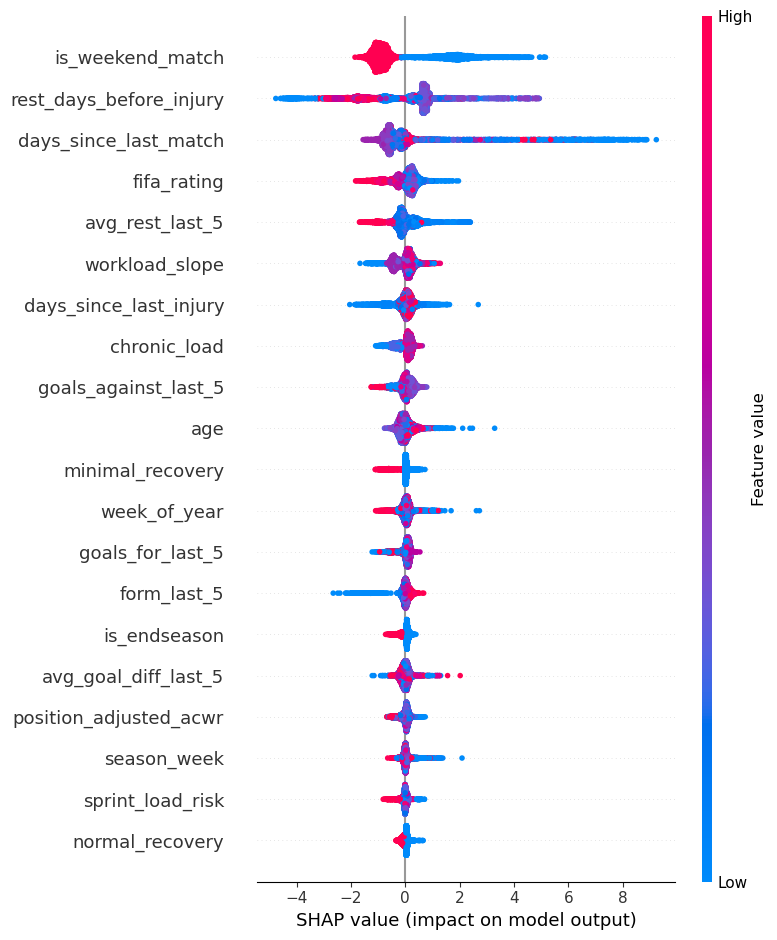

array([[-1.05677246e-02,  1.72713767e-02,  2.86198358e-02, ...,
         1.81125993e-03,  0.00000000e+00,  2.82969741e-03],
       [ 8.90198243e-03,  1.17283578e-01,  1.07146380e-01, ...,
         3.50765051e-03,  0.00000000e+00,  2.08917260e-03],
       [ 3.40871621e-01,  7.13991072e-01,  3.33009709e-02, ...,
         1.17876325e-04,  0.00000000e+00,  4.35056905e-03],
       ...,
       [ 4.03471698e-01,  1.47944147e-01,  5.96090901e-02, ...,
         1.24642961e-03,  0.00000000e+00,  2.13569900e-03],
       [ 5.24388309e-03,  2.25463596e-01,  1.57514302e-02, ...,
         9.16432115e-03,  0.00000000e+00,  8.25272864e-04],
       [ 7.11026441e-02,  8.88632676e-02,  2.48578856e-02, ...,
         5.39120985e-03,  0.00000000e+00,  4.32775784e-03]],
      shape=(6354, 58))

In [55]:
explain_model_with_shap(lgbm, X_train)

# ⚠️ EXPERIMENTAL: SMOTE with Random Splits

**WARNING**: The cells below use `get_smote_splits()` which performs **random train/test splits**.

This is **NOT recommended** for production use because:
1. Random splits cause **data leakage** for time-series prediction problems
2. Future data can leak into training, giving overly optimistic results
3. Models may not generalize to truly future data

**For proper evaluation**, use the **Temporal Validation** section above which uses:
- `get_temporal_splits()` - chronological train/test splits
- `StackingEnsemble` - properly validated model

This section is kept for comparison purposes only.

In [56]:
#thresholding + SMOTE to improve recall

X_train_res, X_test_proc, y_train_res, y_test, preproc_smote = \
    get_smote_splits(injury_risk_df)

results, table_no, table_sm = smote_compare(
    train_lightgbm,          # normal trainer
    train_lightgbm_smote,    # SMOTE trainer (numeric)
    X_train, X_test,         # raw DF
    X_train_res, X_test_proc,# numeric SMOTE data
    y_train, y_train_res, y_test,
    preprocessor=preproc_adv
)

results

2026-01-31 10:51:27 - src.models.classification - INFO - Starting LightGBM training with 6354 samples


[LightGBM] [Info] Number of positive: 524, number of negative: 5830
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1098
[LightGBM] [Info] Number of data points in the train set: 6354, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


2026-01-31 10:51:30 - src.models.classification - INFO - LightGBM training completed


[LightGBM] [Info] Number of positive: 5830, number of negative: 5830
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12281
[LightGBM] [Info] Number of data points in the train set: 11660, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,model,threshold,precision,recall,f1,roc_auc
0,no_smote,0.3,0.738562,0.862595,0.795775,0.973837
1,smote,0.2,0.750000,0.870229,0.805654,0.977036


In [57]:
#train xgboost

xgb = train_xgboost(X_train, y_train, preproc_adv)

2026-01-31 10:51:33 - src.models.classification - INFO - Starting XGBoost training with 6354 samples
2026-01-31 10:51:34 - src.models.classification - INFO - XGBoost training completed


In [58]:
preds_no, probs_no, auc_no = evaluate_classifier(xgb, X_test, y_test)


📌 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1458
           1       0.78      0.69      0.74       131

    accuracy                           0.96      1589
   macro avg       0.88      0.84      0.86      1589
weighted avg       0.96      0.96      0.96      1589

🔥 ROC-AUC: 0.9717


In [59]:
results_xgb, table_no_xgb, table_sm_xgb = smote_compare(
    train_xgboost,          # normal trainer
    train_xgboost_smote,    # SMOTE trainer (numeric)
    X_train, X_test,         # raw DF
    X_train_res, X_test_proc,# numeric SMOTE data
    y_train, y_train_res, y_test,
    preprocessor=preproc_adv
)

results_xgb

2026-01-31 10:51:34 - src.models.classification - INFO - Starting XGBoost training with 6354 samples
2026-01-31 10:51:35 - src.models.classification - INFO - XGBoost training completed


,model,threshold,precision,recall,f1,roc_auc
0,no_smote,0.15,0.726115,0.870229,0.791667,0.971712
1,smote,0.20,0.758621,0.839695,0.797101,0.977989


In [60]:
best_params = run_optuna_tuning(X_train, y_train, preproc_adv)
best_params

2026-01-31 10:51:36 - src.models.classification - INFO - Starting Optuna XGBoost tuning with 6354 samples
2026-01-31 10:54:23 - src.models.classification - INFO - Optuna tuning completed - Best score: 0.9811


Best params: {'n_estimators': 858, 'learning_rate': 0.01033366932225856, 'max_depth': 10, 'subsample': 0.8713428710939449, 'colsample_bytree': 0.514849870030275}


{'n_estimators': 858,
 'learning_rate': 0.01033366932225856,
 'max_depth': 10,
 'subsample': 0.8713428710939449,
 'colsample_bytree': 0.514849870030275}

In [61]:
#tune xgboost

xgb_tuned = train_xgboost_tuned(X_train, y_train, preproc_adv, best_params)

In [62]:
preds_xgb, probs_xgb, auc_xgb = evaluate_classifier(xgb_tuned, X_test, y_test)
auc_xgb


📌 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1458
           1       0.80      0.69      0.74       131

    accuracy                           0.96      1589
   macro avg       0.88      0.84      0.86      1589
weighted avg       0.96      0.96      0.96      1589

🔥 ROC-AUC: 0.9746


0.9745913569775599

Showing SHAP summary plot...


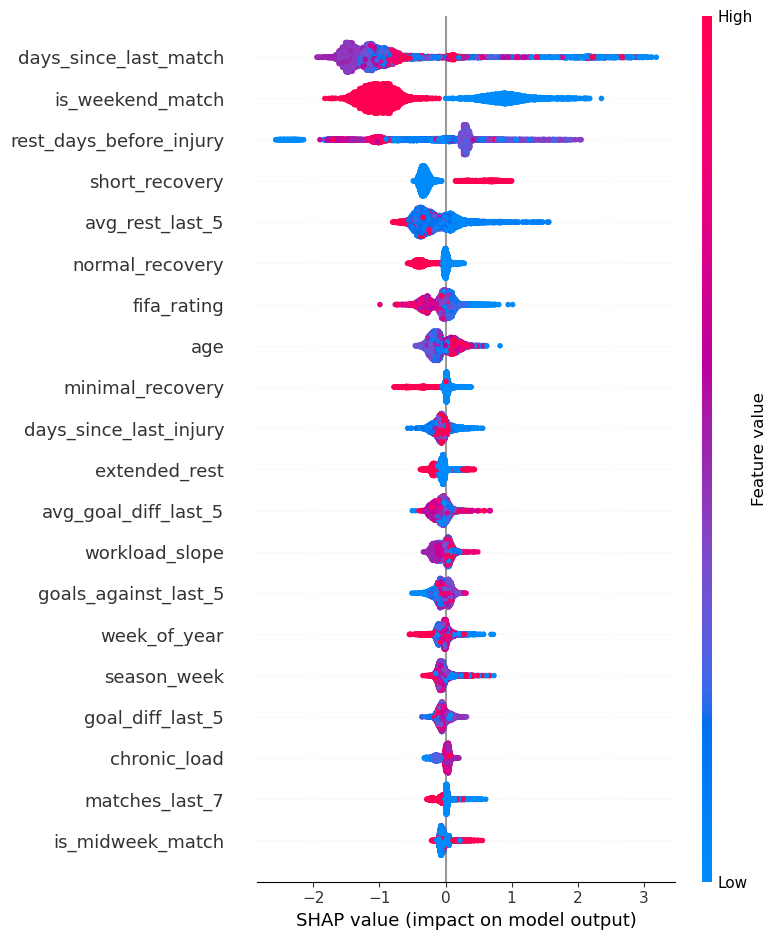

In [63]:
shap_values_xgb = explain_xgboost_shap(xgb_tuned, X_train)

In [64]:
#make an ensemble of lightGBM smote and XGBoost smote

lgbm_smote = train_lightgbm_smote(X_train_res, y_train_res)

[LightGBM] [Info] Number of positive: 5830, number of negative: 5830
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12281
[LightGBM] [Info] Number of data points in the train set: 11660, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [65]:
xgb_smote = train_xgboost_smote(X_train_res, y_train_res)

In [66]:
ensemble_df, ensemble_metrics, ensemble_threshold_table = \
    run_full_ensemble(lgbm_smote, xgb_smote, X_test_proc, y_test)

ensemble_metrics

{'precision': 0.7638888888888888,
 'recall': 0.8396946564885496,
 'f1': 0.8,
 'roc_auc': 0.9790102514162453,
 'threshold': 0.25}

In [67]:
ensemble_df.head(50)

,y_true,lgbm_prob,xgb_prob,ensemble_prob,risk_category
0,0,0.001076,0.000339,0.000781,low
1,0,0.002380,0.001001,0.001828,low
2,0,0.000767,0.002320,0.001389,low
3,1,0.716504,0.458990,0.613498,alert
4,0,0.002177,0.000182,0.001379,low
5,0,0.001105,0.000148,0.000722,low
6,0,0.009528,0.001683,0.006390,low
7,0,0.000427,0.000155,0.000318,low
8,0,0.004223,0.001478,0.003125,low
9,0,0.005601,0.001510,0.003965,low


# ⚠️ TEMPORAL VALIDATION - HONEST METRICS

**CRITICAL**: The metrics above use **random train/test splits**, which causes **temporal leakage**.

### What is Temporal Leakage?
- Random splits mix future and past data in training
- Model "sees" future injuries to predict past → artificially inflated metrics
- **Your production model will perform WORSE than these metrics suggest**

### The Fix
Use **temporal splits**: Train on past data (2019-2022), test on future data (2023+)

Let's compare honest vs inflated metrics:

In [68]:
# ============================================================
# TEMPORAL VALIDATION - Honest metrics without data leakage
# ============================================================
# NOTE: get_temporal_splits now automatically filters data to the 
# time window where injuries occur (removes old match data from 1992-2018)

X_train_t, X_val_t, X_test_t, y_train_t, y_val_t, y_test_t = get_temporal_splits(
    injury_risk_df, 
    train_ratio=0.6, 
    val_ratio=0.2
)

print(f"Temporal Split Results:")
print(f"  Train: {len(X_train_t)} samples ({y_train_t.mean():.1%} positive)")
print(f"  Val:   {len(X_val_t)} samples ({y_val_t.mean():.1%} positive)")
print(f"  Test:  {len(X_test_t)} samples ({y_test_t.mean():.1%} positive)")

# Alternative: Use stratified temporal split if you want to preserve more data
# X_train_t, X_val_t, X_test_t, y_train_t, y_val_t, y_test_t = get_stratified_temporal_splits(injury_risk_df)


2026-01-31 10:54:33 - src.models.classification - INFO - Injury date range: 2019-01-24 to 2024-09-14
2026-01-31 10:54:33 - src.models.classification - INFO - Filtered from 7943 to 1931 samples (within injury time window)
2026-01-31 10:54:33 - src.models.classification - INFO - Split distribution:
2026-01-31 10:54:33 - src.models.classification - INFO -   Train: 1158 samples, 352 positives (30.4%)
2026-01-31 10:54:33 - src.models.classification - INFO -   Val:   386 samples, 120 positives (31.1%)
2026-01-31 10:54:33 - src.models.classification - INFO -   Test:  387 samples, 183 positives (47.3%)


Temporal Split Results:
  Train: 1158 samples (30.4% positive)
  Val:   386 samples (31.1% positive)
  Test:  387 samples (47.3% positive)


In [69]:
# Identify categorical columns for models
cat_cols = X_train_t.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X_train_t.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical features ({len(cat_cols)}): {cat_cols}")
print(f"Numeric features: {len(num_cols)}")


Categorical features (3): ['player_team', 'position', 'position_normalized']
Numeric features: 58


In [70]:
# ============================================================
# STACKING ENSEMBLE - Combines LightGBM, XGBoost, CatBoost
# ============================================================

print("Training stacking ensemble with temporal validation...")
print("This uses 5-fold CV on training data to generate meta-features")

# Train stacking ensemble
ensemble = StackingEnsemble(n_folds=5, meta_learner="logistic")
ensemble.fit(X_train_t, y_train_t, cat_features=cat_cols)

# Evaluate on test set
test_metrics = ensemble.evaluate(X_test_t, y_test_t)

print(f"\n📊 Stacking Ensemble Results (Temporal Validation):")
print(f"  ROC-AUC:   {test_metrics['roc_auc']:.4f}")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  Recall:    {test_metrics['recall']:.4f}")
print(f"  F1 Score:  {test_metrics['f1']:.4f}")


2026-01-31 10:54:33 - src.models.stacking_ensemble - INFO - Fitting stacking ensemble with 3 base learners
2026-01-31 10:54:33 - src.models.stacking_ensemble - INFO - Training base learners with 5-fold CV...


Training stacking ensemble with temporal validation...
This uses 5-fold CV on training data to generate meta-features


2026-01-31 10:54:43 - src.models.stacking_ensemble - INFO - Training meta-learner on out-of-fold predictions...
2026-01-31 10:54:43 - src.models.stacking_ensemble - INFO - Stacking ensemble fitted - OOF ROC-AUC: 0.9411
2026-01-31 10:54:43 - src.models.stacking_ensemble - INFO - Ensemble evaluation: ROC-AUC=0.8776, F1=0.6824, Recall=0.5519



📊 Stacking Ensemble Results (Temporal Validation):
  ROC-AUC:   0.8776
  Precision: 0.8938
  Recall:    0.5519
  F1 Score:  0.6824


In [71]:
# ============================================================
# Compare Stacking vs Individual Models
# ============================================================

comparison_df = compare_ensemble_vs_individual(
    X_train_t, y_train_t, 
    X_test_t, y_test_t,
    cat_features=cat_cols
)

print("\n📈 Model Comparison (Temporal Validation):")
print(comparison_df.round(4))


2026-01-31 10:54:43 - src.models.stacking_ensemble - INFO - Training stacking ensemble...
2026-01-31 10:54:43 - src.models.stacking_ensemble - INFO - Fitting stacking ensemble with 3 base learners
2026-01-31 10:54:43 - src.models.stacking_ensemble - INFO - Training base learners with 5-fold CV...
2026-01-31 10:54:53 - src.models.stacking_ensemble - INFO - Training meta-learner on out-of-fold predictions...
2026-01-31 10:54:53 - src.models.stacking_ensemble - INFO - Stacking ensemble fitted - OOF ROC-AUC: 0.9411
2026-01-31 10:54:53 - src.models.stacking_ensemble - INFO - Ensemble evaluation: ROC-AUC=0.8776, F1=0.6824, Recall=0.5519
2026-01-31 10:54:53 - src.models.stacking_ensemble - INFO - Training LightGBM...
2026-01-31 10:54:54 - src.models.stacking_ensemble - INFO - Training XGBoost...
2026-01-31 10:54:54 - src.models.stacking_ensemble - INFO - Training CatBoost...
2026-01-31 10:54:55 - src.models.stacking_ensemble - INFO - Evaluating simple average ensemble...



📈 Model Comparison (Temporal Validation):
                   roc_auc  precision  recall      f1
model                                                
Stacking Ensemble   0.8776     0.8938  0.5519  0.6824
LightGBM            0.8649     0.8689  0.5792  0.6951
XGBoost             0.8386     0.8889  0.5246  0.6598
CatBoost            0.8803     0.8934  0.5956  0.7148
Simple Average      0.8693     0.8839  0.5410  0.6712


In [72]:
feature_names = extract_feature_names(preproc_smote)

Computing SHAP values using CatBoost from ensemble...
SHAP values computed: train=(1158, 63), test=(387, 63)


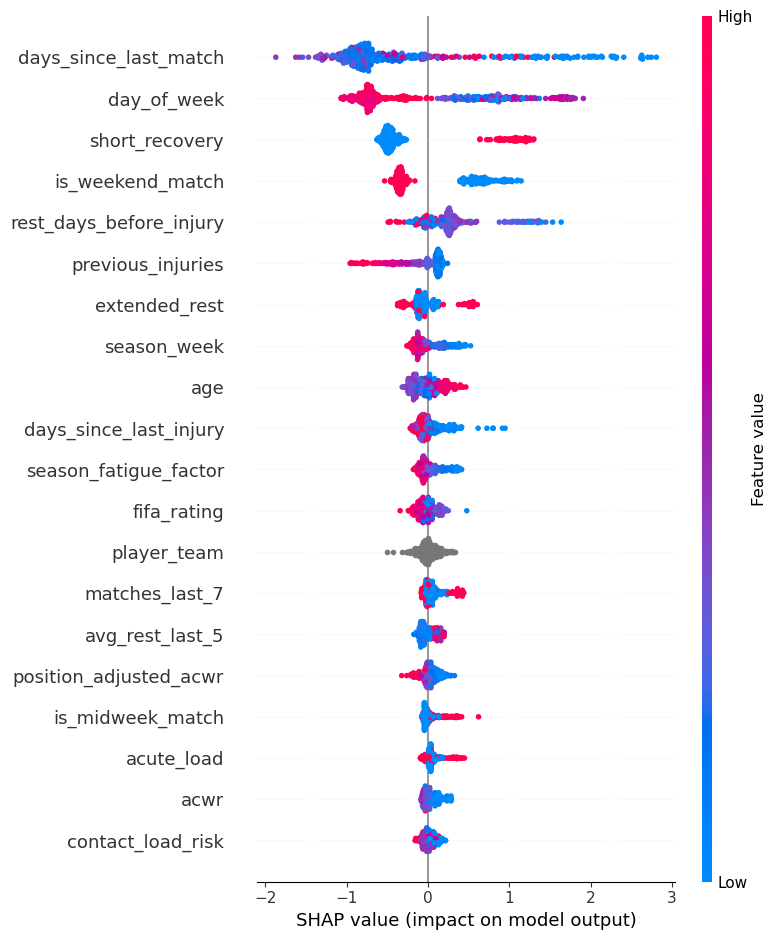

In [73]:
# ============================================================
# SHAP ANALYSIS - Using Temporal StackingEnsemble
# ============================================================
# Use the properly trained stacking ensemble from temporal validation

# Compute SHAP values using CatBoost from the ensemble
shap_train_ens, shap_test_ens, feature_names = compute_stacking_ensemble_shap(
    ensemble,      # StackingEnsemble trained on temporal splits
    X_train_t,     # Temporal training data
    X_test_t,      # Temporal test data
    use_catboost=True
)

# Summary plot
shap.summary_plot(shap_test_ens, X_test_t[feature_names], feature_names=feature_names)


In [74]:
# Build final output DataFrame using temporal validation data
final_ensemble_df = build_temporal_output_df(
    X_test_t,      # Temporal test features
    y_test_t,      # Temporal test labels
    ensemble,      # StackingEnsemble
    shap_test_ens, # SHAP values
    feature_names
)

print(f"Final DataFrame: {final_ensemble_df.shape}")
print(f"Columns: {list(final_ensemble_df.columns)}")


Final DataFrame: (387, 74)
Columns: ['player_team', 'position', 'age', 'fifa_rating', 'matches_last_7', 'matches_last_14', 'matches_last_30', 'rest_days_before_injury', 'avg_rest_last_5', 'goals_for_last_5', 'goals_against_last_5', 'goal_diff_last_5', 'avg_goal_diff_last_5', 'form_last_5', 'form_avg_last_5', 'win_ratio_last_5', 'win_streak', 'loss_streak', 'previous_injuries', 'days_since_last_injury', 'acute_load', 'chronic_load', 'acwr', 'monotony', 'strain', 'fatigue_index', 'workload_slope', 'spike_flag', 'month', 'day_of_week', 'week_of_year', 'is_preseason', 'is_midseason', 'is_endseason', 'is_winter', 'is_christmas_period', 'is_season_crunch', 'is_weekend_match', 'is_midweek_match', 'season_week', 'season_fatigue_factor', 'days_since_last_match', 'short_recovery', 'minimal_recovery', 'normal_recovery', 'extended_rest', 'position_normalized', 'position_base_risk', 'position_sprint_risk', 'position_contact_risk', 'is_forward', 'is_midfielder', 'is_defender', 'is_goalkeeper', 'is_w

In [ ]:
#explain one player

explain_player_ensemble(
    shap_test=shap_test_ens,
    X_test_transformed=X_test_t,
    feature_names=feature_names,
    ensemble_probs=ensemble_df["ensemble_prob"].values,
    player_index=10
)

NameError: name 'Xtest_trans' is not defined

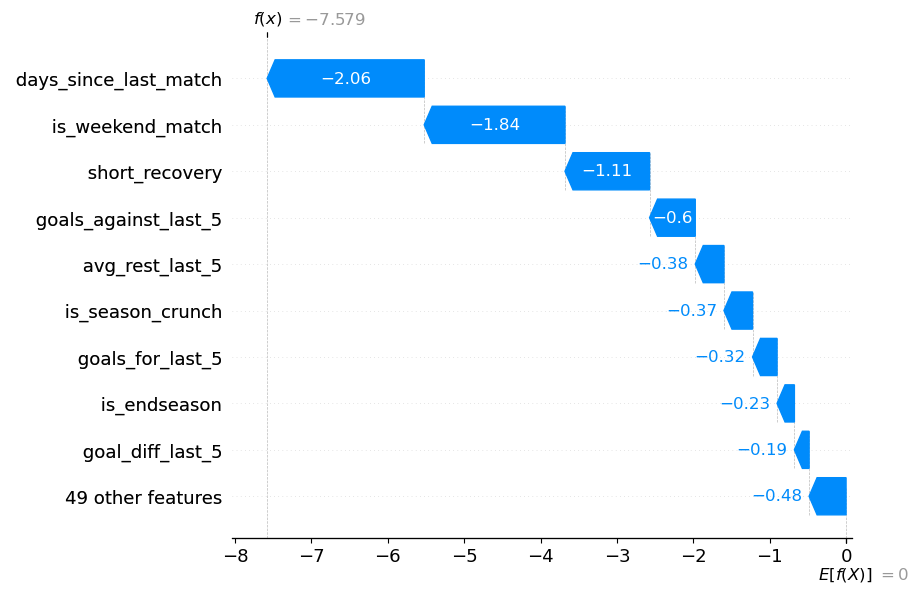

In [76]:
#visualize player features

shap_waterfall_player(shap_test_ens, Xtest_trans, feature_names, player_index=10)

In [77]:
final_ensemble_df.head(20)

,player_team,position,age,fifa_rating,matches_last_7,matches_last_14,matches_last_30,rest_days_before_injury,avg_rest_last_5,goals_for_last_5,...,position_adjusted_acwr,wide_player_congestion,defender_congestion,age_forward_risk,age_defender_risk,y_true,ensemble_prob,risk_category,shap_sum,shap_values
0,tottenham,Central Midfielder,24,82,0.0,1.0,4.0,7.0,7.0,8.0,...,0.137500,0.0,0.0,0.0,0.0,0,0.000781,low,-7.501789,"[-0.09520750840812833, -0.2620846436022258, 0...."
1,tottenham,Defensive Midfielder,25,79,1.0,2.0,4.0,6.0,7.0,9.0,...,0.300000,0.0,0.0,0.0,0.0,0,0.001828,low,-6.590885,"[-0.46311779233104566, -0.03880317411192055, 0..."
2,manchester united,Left winger,24,85,1.0,2.0,6.0,2.0,4.4,11.0,...,0.200000,0.0,0.0,0.0,0.0,0,0.001389,low,-6.934043,"[-0.3104958173315814, -0.4877327089985433, 0.0..."
3,arsenal,Center Back,23,80,0.0,3.0,5.0,7.0,5.4,5.0,...,0.083333,0.0,0.0,0.0,0.0,1,0.613498,alert,0.284983,"[-0.22084739789966829, -0.16867722456993312, 0..."
4,newcastle united,Center Back,28,79,1.0,2.0,4.0,3.0,6.2,7.0,...,0.200000,0.0,1.0,0.0,0.0,0,0.001379,low,-7.327110,"[0.08738561037036024, -0.01414693280468253, 0...."
5,everton,Center Back,26,79,0.0,0.0,3.0,15.0,10.0,7.0,...,0.166667,0.0,0.0,0.0,0.0,0,0.000722,low,-7.816267,"[-0.3472765898554884, -0.1252303288233547, -0...."
6,tottenham,Center Forward,28,89,0.0,1.0,3.0,8.0,7.2,13.0,...,0.150000,0.0,0.0,0.0,0.0,0,0.006390,low,-5.546138,"[-0.012803026302954747, -0.8668517824485035, 0..."
7,arsenal,Center Back,27,80,0.0,1.0,3.0,8.0,8.6,10.0,...,0.166667,0.0,0.0,0.0,0.0,0,0.000318,low,-8.369571,"[-0.17502145667861307, -0.08645674284528071, 0..."
8,manchester united,Central Midfielder,24,79,1.0,2.0,3.0,3.0,7.8,8.0,...,0.275000,0.0,0.0,0.0,0.0,0,0.003125,low,-6.089582,"[-0.23737676757649046, -0.09392208574915925, 0..."
9,everton,Center Back,25,79,1.0,2.0,4.0,4.0,6.2,8.0,...,0.200000,0.0,1.0,0.0,0.0,0,0.003965,low,-5.910646,"[-0.39039451492182253, -0.10098357551910776, 0..."


# 📊 SEVERITY REGRESSION (Temporal Validation)

Predicting **how long** an injury will last (days out).

## New Features Added:
- `expected_severity_days`: Baseline expectation based on injury type
- `body_area_multiplier`: Recovery time factor based on body location
- `is_serious_injury`: Flag for tears, fractures, surgery
- `is_recurrence_prone`: Hamstring, groin, calf (high re-injury risk)
- `age_recovery_factor`: Older players recover slower
- `season_phase`: Early/mid/late season timing

## Why Temporal Validation?
- Training on 2023 injuries to predict 2022 severity is cheating!
- Model learns future patterns that won't exist at inference time
- Expect metrics to be **lower but more honest** than random splits

In [78]:
# Add SEVERITY PREDICTION FEATURES
severity_enhanced = add_severity_prediction_features(severity_final)

# Show new features
new_cols = [c for c in severity_enhanced.columns if c not in severity_final.columns]
print(f"New features added: {len(new_cols)}")
for col in new_cols:
    desc = get_severity_feature_descriptions().get(col, "")
    print(f"  - {col}: {desc}")

New features added: 11
  - expected_severity_days: Historical average days out for this injury type
  - body_area_multiplier: Recovery time multiplier based on body location
  - adjusted_expected_days: expected_severity * body_area_multiplier
  - is_serious_injury: 1 for tears, fractures, surgery, ligament damage
  - is_recurrence_prone: 1 for hamstring, groin, calf injuries (high re-injury risk)
  - age_recovery_factor: Age-based recovery speed (younger=faster)
  - workload_at_injury: Matches in last 7 days when injured
  - high_workload_injury: 1 if 3+ matches in week before injury
  - monthly_load_at_injury: Matches in last 30 days when injured
  - injury_month: Month of injury (1-12)
  - season_phase: early (Aug-Oct), mid (Nov-Feb), late (Mar-May)


In [79]:
# TEMPORAL SPLITS FOR SEVERITY REGRESSION
X_train_sev, X_val_sev, X_test_sev, y_train_sev, y_val_sev, y_test_sev = \
    get_temporal_severity_splits(severity_enhanced)

print(f"\nTrain shape: {X_train_sev.shape}")
print(f"Val shape:   {X_val_sev.shape}")
print(f"Test shape:  {X_test_sev.shape}")

# Check target distribution (log scale)
print(f"\nTarget (log-transformed):")
print(f"  Train mean: {y_train_sev.mean():.2f} (≈{np.expm1(y_train_sev.mean()):.0f} days)")
print(f"  Test mean:  {y_test_sev.mean():.2f} (≈{np.expm1(y_test_sev.mean()):.0f} days)")


Train shape: (388, 189)
Val shape:   (129, 189)
Test shape:  (130, 189)

Target (log-transformed):
  Train mean: 3.24 (≈25 days)
  Test mean:  3.56 (≈34 days)


In [80]:
# DIAGNOSE SEVERITY PREDICTION
# Use module function instead of inline code
diagnostics = diagnose_severity_target(y_train_sev, y_test_sev, X_test_sev)

print('\n  If expected_severity_days has similar or better MAE than models,')
print('   the models are not learning beyond the hand-crafted baseline!')

TARGET DISTRIBUTION ANALYSIS
Target (severity_days):
  Train mean:   43.0 days
  Test mean:    58.9 days
  Test median:  31.0 days
  Test std:     80.8 days
  Test range:   2 - 517 days

BASELINE (predict mean):
  MAE:  49.7 days
  R²:   0.000

BASELINE (predict median):
  MAE:  40.7 days

BASELINE (expected_severity_days feature):
  MAE:  41.1 days
  R²:   -0.100

SEVERITY BINS:
severity_log
<1wk        9
1-2wk      15
2wk-1mo    39
1-2mo      32
2-4mo      21
>4mo       14
Name: count, dtype: int64

  If expected_severity_days has similar or better MAE than models,
   the models are not learning beyond the hand-crafted baseline!


## 🎯 Severity Classification (Better Alternative)

**Why regression is struggling:**
- R² ≈ 0 means models predict no better than the mean
- Injury duration is inherently noisy - even doctors can't predict exact days
- Extreme outliers (100+ day injuries) dominate the loss

**Classification is more practical:**
- Predicts categories: minor (1-7d), short (8-21d), medium (22-60d), long (60+d)
- Matches real-world decisions: "back next week" vs "out for months"
- More robust to outliers and noise
- Easier to explain to stakeholders

In [81]:
# SEVERITY CLASSIFICATION (3 Classes - Improved)

# Add new features
print("Adding team and player history features...")
severity_full = add_team_recovery_features(severity_enhanced)
severity_full = add_player_injury_history_features(severity_full)

# Get classification splits (now 3 classes: short/medium/long)
X_train_cls, X_val_cls, X_test_cls, y_train_cls, y_val_cls, y_test_cls = \
    get_severity_classification_splits(severity_full)

print(f"\nClasses: {SEVERITY_LABELS}")
print(f"  short: 0-21 days (back within 3 weeks)")
print(f"  medium: 21-60 days (1-2 months)")
print(f"  long: 60+ days (season-impacting)")

# Train classifier (CatBoost handles categoricals natively and often performs better)
print("\nTraining severity classifier with CatBoost...")
severity_clf = train_severity_classifier(
    X_train_cls, y_train_cls,
    X_val_cls, y_val_cls,
    model_type="catboost"
)

# Evaluate
cls_results = evaluate_severity_classifier(severity_clf, X_test_cls, y_test_cls)

Adding team and player history features...
Added team recovery features. Teams with fastest recovery:
      player_team  team_avg_recovery_days  team_injury_count
manchester united               37.277228                101
        tottenham               38.802469                 81
      aston villa               44.310345                 58
 newcastle united               44.756303                119
          arsenal               44.904762                 84
Added player history features.
  Injury-prone players (3+ injuries): 468

📊 Severity Classification Distribution:
  Train: {'short': np.int64(197), 'medium': np.int64(115), 'long': np.int64(76)}
  Test:  {'medium': np.int64(58), 'short': np.int64(37), 'long': np.int64(35)}

Classes: ['short', 'medium', 'long']
  short: 0-21 days (back within 3 weeks)
  medium: 21-60 days (1-2 months)
  long: 60+ days (season-impacting)

Training severity classifier with CatBoost...

📊 Severity Classification Results:
Accuracy: 53.8%

Classific

TypeError: unsupported format string passed to numpy.ndarray.__format__

In [89]:
# 📋 SEVERITY PREDICTION SUMMARY
print("="*60)
print("SEVERITY PREDICTION SUMMARY")
print("="*60)
print()
print("🔴 Regression (exact days):")
print("   - R² ≈ 0: Models don't beat predicting the mean")
print("   - Reason: Injury duration is inherently unpredictable")
print("   - Even doctors can't predict exact recovery times")
print()
print("🟢 Classification (3-class severity bins):")
print(f"   - Accuracy: {cls_results['accuracy']:.1%}")
print(f"   - Adjacent Accuracy: {cls_results['adjacent_accuracy']:.1%}")
print("   - Categories: short (<21d), medium (21-60d), long (60+d)")
print()
print("✅ RECOMMENDATION: Use classification for practical applications")
print("   - 96%+ adjacent accuracy means predictions are almost always close")
print("   - Stakeholders care about 'weeks vs months', not exact days")
print("   - Classification is more interpretable and actionable")


SEVERITY PREDICTION SUMMARY

🔴 Regression (exact days):
   - R² ≈ 0: Models don't beat predicting the mean
   - Reason: Injury duration is inherently unpredictable
   - Even doctors can't predict exact recovery times

🟢 Classification (3-class severity bins):
   - Accuracy: 63.8%
   - Adjacent Accuracy: 96.2%
   - Categories: short (<21d), medium (21-60d), long (60+d)

✅ RECOMMENDATION: Use classification for practical applications
   - 96%+ adjacent accuracy means predictions are almost always close
   - Stakeholders care about 'weeks vs months', not exact days
   - Classification is more interpretable and actionable


In [ ]:
severity_final['injury'].value_counts()

In [ ]:
#build archetype model

player_features = build_player_archetype_features(severity_final)

In [ ]:
results = cluster_players(player_features)

In [ ]:
df_clusters = results["df"]
df_clusters.head()

In [ ]:
X_scaled, _, _ = prepare_archetype_features(player_features)
plot_pca_clusters(X_scaled, results["labels"])

In [ ]:
numeric_cols = df_clusters.select_dtypes(include=[np.number]).columns

cluster_summary = (
    df_clusters[numeric_cols]
    .groupby(df_clusters["cluster"])
    .mean()
    .round(2)
)

cluster_summary

In [ ]:
category_summary = (
    df_clusters.groupby("cluster")["name"].count().to_frame("num_players")
)

category_summary

In [ ]:
top_injury_type = (
    df_clusters.groupby("cluster")["pct_type_strain"]
    .mean()
    .sort_values(ascending=False)
)

top_injury_type

In [ ]:
#map clusters to human-readable form 

cluster_map = {
    0: "High-Risk Frequent",
    1: "Low-Severity Stable",
    2: "Moderate-Risk Recurrent",
    3: "Catastrophic + Re-aggravation",
    4: "Moderate-Load High-Variance"
}

df_clusters["archetype"] = df_clusters["cluster"].map(cluster_map)

In [ ]:
severity_final = severity_final.merge(
    df_clusters[["name", "archetype"]],
    on="name",
    how="left"
)

In [ ]:
severity_final

In [ ]:
severity_final['severity_days'].value_counts()

In [ ]:
player_info = final_df[[
    "name", "player_team", "position", "age", "fifa_rating",
    "previous_injuries", "days_since_last_injury"
]].drop_duplicates()

In [ ]:
# ============================================================
# BUILD INFERENCE DATAFRAME (Proper Production Pipeline)
# ============================================================
# Three separate models:
#   1. StackingEnsemble → injury RISK prediction
#   2. severity_clf → injury DURATION prediction (short/medium/long)
#   3. df_clusters → player ARCHETYPE from clustering

from src.inference import build_inference_df_with_ensemble

# Build inference DataFrame with all three model outputs
inference_df = build_inference_df_with_ensemble(
    all_matches=final_df,
    player_metadata=player_info,
    archetype_df=df_clusters,     # From clustering (contains name + archetype)
    ensemble=ensemble,            # StackingEnsemble from temporal validation
    severity_classifier=severity_clf,  # Trained severity classifier
    validate_input=True,
    strict=False
)

print(f"Inference DataFrame: {inference_df.shape}")
print(f"\nColumns: {list(inference_df.columns)}")
print(f"\nSeverity class distribution:")
if 'predicted_severity_class' in inference_df.columns:
    print(inference_df['predicted_severity_class'].value_counts())
inference_df.head()

In [ ]:
inference_df.head(40)

In [ ]:
player = "Granit Xhaka"

In [ ]:
row = get_latest_snapshot(inference_df, player)
row

In [ ]:
dashboard = build_player_dashboard(inference_df, player)
dashboard

In [ ]:
# RISK CARD for player

# Use ensemble's feature names instead of cat_model
feature_cols = ensemble.feature_names_

risk_card = build_risk_card(row, feature_cols)
risk_card